# **PART 1**
# **EMBEDDING WATERMARK TO COVER IMAGE**

In [ ]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow
from scipy.fftpack import dct
from scipy.fftpack import idct
from skimage.util import random_noise

In [ ]:
def key_sch(c):
  val=ord(c)
  return val%8

In [ ]:
def wm_img_resize(path,size):
    img=cv2.imread(path)
    img=cv2.resize(img,(size,size))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    image_array=np.array(img,dtype=float).reshape((size, size))
    cv2_imshow(img)
    return img,image_array

In [ ]:
def o_img_resize(path,size):
    img=cv2.imread(path)
    img=cv2.resize(img,(size,size))
    image_array=np.array(img,dtype=float).reshape((size, size,3))
    cv2_imshow(img)
    return img,image_array

In [ ]:
def dct_fun(cover_array):
    size=cover_array[0].__len__()
    dcm = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            blk_pxl = cover_array[i:i+8, j:j+8]
            dcm[i:i+8, j:j+8] = dct(dct(blk_pxl.T, norm="ortho").T, norm="ortho")
    return dcm

In [ ]:
def wm_embedding(wm_array, dcm,key):
    modify_dcm = dcm
    wm_flat = wm_array.ravel()
    idx = 0 
    k=0  
    for x in range (0, dcm.__len__(), 8):
        for y in range (0, dcm.__len__(), 8):
            if(k>=len(key)):
              k=0
            if idx < wm_flat.__len__():
                blkdct = dcm[x:x+8, y:y+8]
                i=key_sch(key[k])
                if(i==0):
                  i=6
                blkdct[i][i] = wm_flat[idx]
                modify_dcm[x:x+8, y:y+8] = blkdct
                idx += 1 
                k=k+1
    return modify_dcm

In [ ]:
def inv_dct(mod_dcm):
    size = mod_dcm[0].__len__()
    idct_img = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            blkdct = idct(idct(mod_dcm[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            idct_img[i:i+8, j:j+8] = blkdct
    return idct_img

In [ ]:
def PSNR_val(original, secretImage): 
    mse = np.mean((secretImage-original) ** 2) 
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    
    psnr = 20 * np.log10(max_pixel/np.sqrt(mse)) 
    return psnr 

In [ ]:
def Embed_operation(img_path,wm_path,key):
    #resizing and printing images
    #Resize the original image and watermark image for efficient partition in blocks.
    print("Resized original image\n")
    r_o_img,o_array = o_img_resize(img_path,512)

    print("Resized Watermark image\n")  
    r_wm_img,wm_array = wm_img_resize(wm_path,64)

#applying dct
    wm_array = wm_array/255 
    dcm = dct_fun(o_array[:,:,0]) #calling dct and storing the equivalent coeficient to b.
    

#embedding the watermark to the cover image
    mod_dcm = wm_embedding(wm_array,dcm,key)

#now applying inverse dct to transform cover image back to spatial domain
    idct_img = inv_dct(mod_dcm)

#printing embeded cover image
    print("After applying Inverse dct:\n")
    cv2_imshow(idct_img)

    embed_img = np.zeros((512,512,3))
    embed_img[:,:,0] = idct_img
    embed_img[:,:,1] = o_array[:,:,1]
    embed_img[:,:,2] = o_array[:,:,2]

    print("Finally Embeded Image:\n")
    cv2_imshow(embed_img)
#saving the embeded image
    cv2.imwrite("/content/watermarkedimg.jpg",embed_img)
#printing the psnr value
    print("PSNR value initial cover w.r.t embeded cover image\n")
    print(PSNR_val(r_o_img,embed_img))

    return r_wm_img,embed_img,idct_img


In [ ]:
def extract_wm(dct_watermarked_image, watermark_size,key):
    subwatermarks = []
    k=0
    for x in range (0, dct_watermarked_image.__len__(), 8):
        for y in range (0, dct_watermarked_image.__len__(), 8):
            if(k>=len(key)):
              k=0
            islice = dct_watermarked_image[x:x+8, y:y+8]
            i=key_sch(key[k])
            if(i==0):
              i=6
            subwatermarks.append(islice[i][i]) 
            k=k+1        
    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)*255
    watermark =  np.uint8(watermark)
    return watermark

In [ ]:
def extraction_operation(r_wm_img,embed_img,idct_img,key):
    
    transform_img = dct_fun(idct_img)

    recovered_wm_img = extract_wm(transform_img,r_wm_img.__len__(),key)
    
    print("Given Initial/Original Watermark Image :\n")
    cv2_imshow(r_wm_img)
    
    print("Extracted Watermark Image :\n")
    cv2_imshow(recovered_wm_img)
    
    print("PSNR Value of Extracted Watermark Image  w.r.t Original Watermark Image\n")
    print(PSNR_val(r_wm_img,recovered_wm_img))


# **Main Function**

Enter Key: abc123
Resized original image



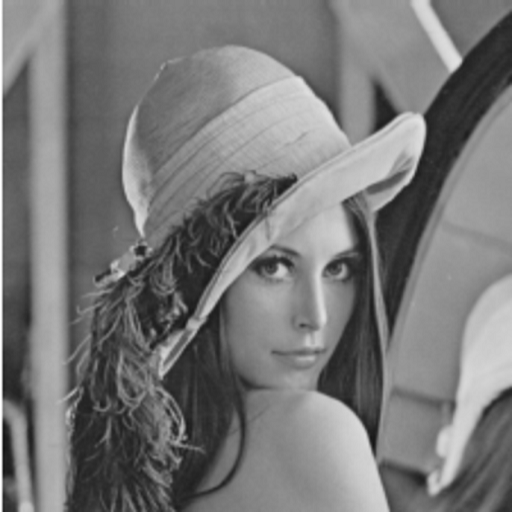

Resized Watermark image



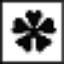

After applying Inverse dct:



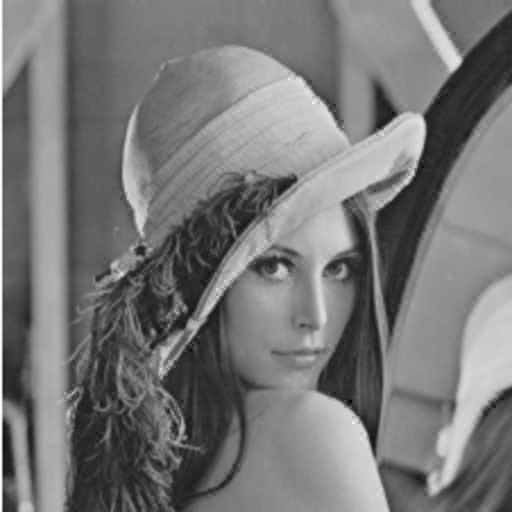

Finally Embeded Image:



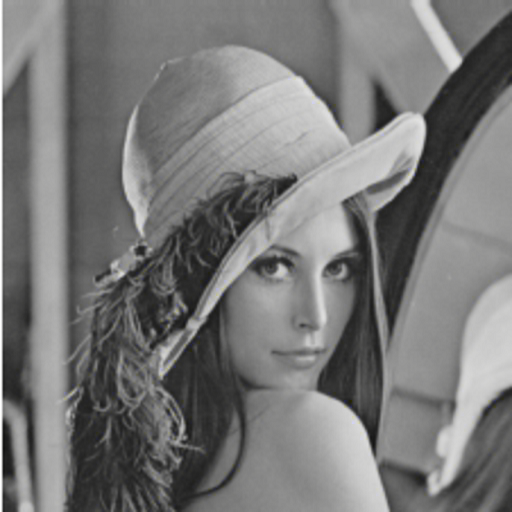

PSNR value initial cover w.r.t embeded cover image

45.85758439268194
Given Initial/Original Watermark Image :



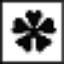

Extracted Watermark Image :



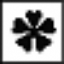

PSNR Value of Extracted Watermark Image  w.r.t Original Watermark Image

51.17730385430878


In [ ]:
#creating path variable to store path of images.
wm_path = "/content/logo.png"
img_path = "/content/lena.png"

#reading image from given path
wm_img = cv2.imread(wm_path)
o_img = cv2.imread(img_path)

#printing the read images
#print("Original Image : \n")
#cv2_imshow(o_img)
#print("Watermark Image : \n")
#cv2_imshow(wm_img)

key=input("Enter Key: ")

#Embedding Operation
r_wm_img,embed_img,idct_img = Embed_operation(img_path,wm_path,key)

#Extraction Operation
extraction_operation(r_wm_img,embed_img,idct_img,key)





# **PART 2** 
# **ATTACKS**

In [ ]:
def noisy(noise_typ,img):
    if noise_typ == "gauss":
        row,col,ch= img.shape
        mean = 0
        var = 0.001
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = img + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = img.shape
        s_vs_p = 0.5
        amount = 0.01
        out = np.copy(img)
        # Salt mode
        num_salt = np.ceil(amount * img.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in img.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* img.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in img.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(img))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(img * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = img.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = img + img * gauss
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = img.shape[1]
        h = img.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(img, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = img.copy()
        w, h = img.shape[:2]
        noisy=img[int(w * 0.3):, :]
        return noisy


image with rotate 90 


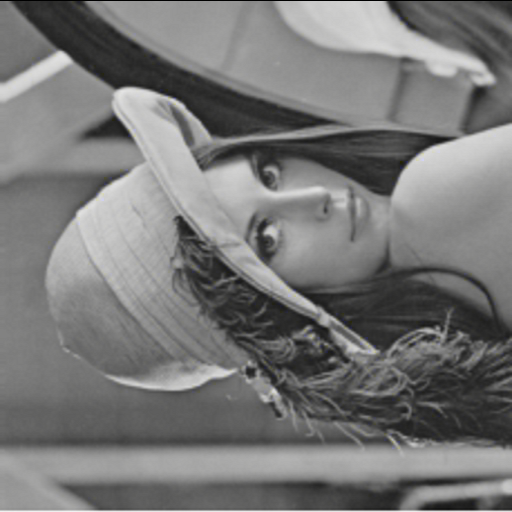

Noisy watermark image recovered 


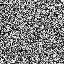

NC value of the extracted logo = [[0.7264509]]

PSNR value noisy watermark image  w.r.t watermark image 


27.938423317801487

In [ ]:
noise_img=noisy("rotate90",embed_img)
print("image with rotate 90 ")
cv2_imshow(noise_img)
water_recov=extract_wm(dct_fun(noise_img[:,:,0]),64,key)
print("Noisy watermark image recovered ")
cv2_imshow(water_recov)
nc_res = cv2.matchTemplate(r_wm_img, water_recov,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}\n'.format(nc_res))
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR_val(r_wm_img,water_recov)


image with Pepper and Salt Noise 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


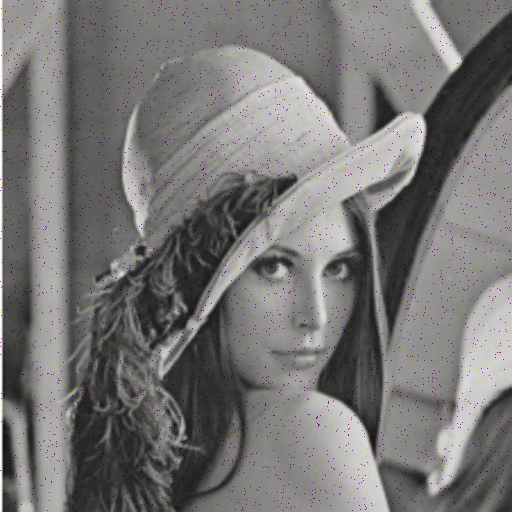

Noisy watermark image recovered 


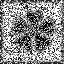

NC value of the extracted logo = [[0.8452652]]

PSNR value noisy watermark image  w.r.t watermark image 


30.151136260820728

In [ ]:
noise_img=noisy("s&p",embed_img)
print("image with Pepper and Salt Noise ")
cv2_imshow(noise_img)
water_recov=extract_wm(dct_fun(noise_img[:,:,0]),64,key)
print("Noisy watermark image recovered ")
cv2_imshow(water_recov)
nc_res = cv2.matchTemplate(r_wm_img, water_recov,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}\n'.format(nc_res))
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR_val(r_wm_img,water_recov)


image with Gaussian Noise


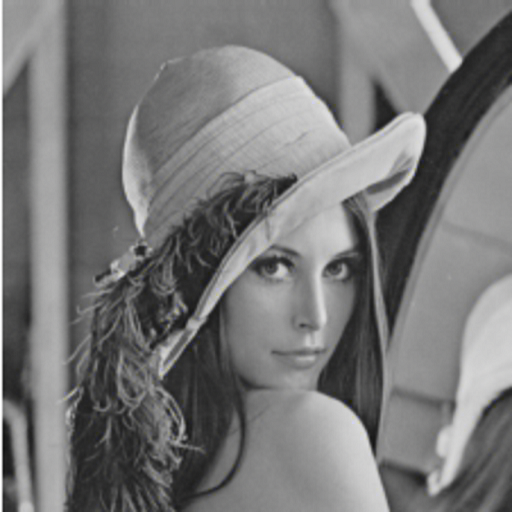

Noisy watermark image recovered 


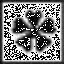

NC value of the extracted logo = [[0.8032604]]

PSNR value noisy watermark image  w.r.t watermark image 


31.13411128810149

In [ ]:
noise_img=noisy("gauss",embed_img)
water_recov=extract_wm(dct_fun(noise_img[:,:,0]),64,key)
print("image with Gaussian Noise")
cv2_imshow(noise_img)
print("Noisy watermark image recovered ")
cv2_imshow(water_recov)
nc_res = cv2.matchTemplate(r_wm_img, water_recov,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}\n'.format(nc_res))
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR_val(r_wm_img,water_recov)


image with specle Noise


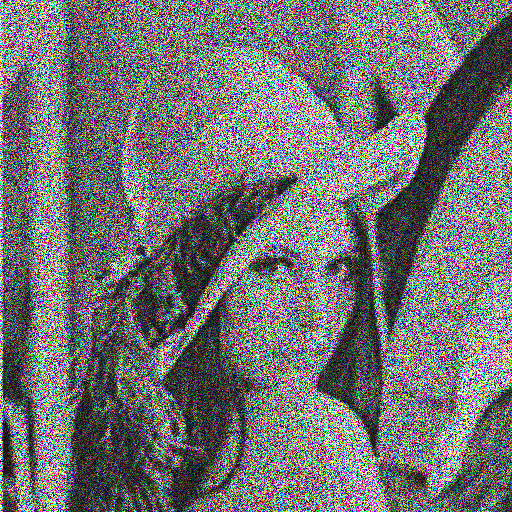

Noisy watermark image recovered 


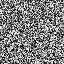

NC value of the extracted logo = [[0.7272136]]

PSNR value noisy watermark image  w.r.t watermark image 


27.89383912286104

In [ ]:
noise_img=noisy("speckle",embed_img)
water_recov=extract_wm(dct_fun(noise_img[:,:,0]),64,key)
print("image with specle Noise")
cv2_imshow(noise_img)
print("Noisy watermark image recovered ")
cv2_imshow(water_recov)
nc_res = cv2.matchTemplate(r_wm_img, water_recov,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}\n'.format(nc_res))
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR_val(r_wm_img,water_recov)


*********************************************